<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C4/C4.html"><img src="../data/C4_nav.png" width="100"  style="float:right;" alt="C4"></a>
<h1>SSM: Synthetic Generation</h1> 
</div>

<br/>

<p>
In this notebook, we show how one may synthetically generate self-similarity matrices from structure annotations. In particular, based on the notions introduced in Section 4.2.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we consider SSMs with path and block structures. 
</p> 

## Annotations

In previous notebooks, we have looked at the [Hungarian Dance No. 5 by Johannes Brahms](../C4/C4S1_MusicStructureGeneral.html), which has the musical structure $A_1A_2B_1B_2CA_3B_3B_4D$. Starting with an audio recording of the piece, the goal is not only to derive a **symbolic** description of the musical structure, but also to determine the exact time positions when the structural parts start and end. Let us have a look at the Ormandy recording of the Brahms piece.  

<img src="../data/C4/FMP_C4_F07a.png" width="280px" align="left" alt="FMP_C4_F07a.png">

<br clear="all" />
<audio style="width: 280px;" src="../data/C4/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.mp3" type="audio/mpeg" controls="controls"></audio>

In the following, we read in and visualize a structural annotation of this recording (see the [FMP notebook on annotations](../B/B_Annotations.html) and the [FMP notebook on music structure analysis](../C4/C4S1_MusicStructureGeneral.html) for more details). In this example, each musical part corresponds to a tuple specifying the start time and the end time (given in seconds) as well as the label for the part.

,start,end,label
0,0.00,1.01,
1,1.01,22.11,A1
2,22.11,43.06,A2
3,43.06,69.42,B1
4,69.42,89.57,B2
5,89.57,131.64,C
6,131.64,150.84,A3
7,150.84,176.96,B3
8,176.96,196.90,B4
9,196.90,199.64,


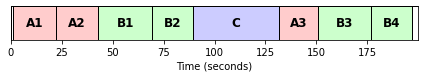

Annotations after sampling rate conversion and removal of digits:


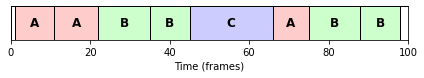

In [1]:
import numpy as np
import os, sys, librosa
from matplotlib import pyplot as plt
import scipy.ndimage
import IPython.display as ipd
import pandas as pd

sys.path.append('..')
import libfmp.b
import libfmp.c4
%matplotlib inline

# Annotation
filename = 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.csv'
fn_ann = os.path.join('..', 'data', 'C4', filename)
df = libfmp.b.read_csv(fn_ann)
ipd.display(ipd.HTML(df.to_html()))

ann, color_ann = libfmp.c4.read_structure_annotation(fn_ann, fn_ann_color=filename)
fig, ax = libfmp.b.plot_segments(ann, colors=color_ann, figsize=(6, 1))
plt.xlabel('Time (seconds)');
plt.show()

print('Annotations after sampling rate conversion and removal of digits:')

ann_frames, color_ann = libfmp.c4.read_structure_annotation(fn_ann, fn_ann_color=filename, 
                                                            Fs=0.5, remove_digits=True, index=True)
fig, ax = libfmp.b.plot_segments(ann_frames, colors=color_ann, figsize=(6, 1))
plt.xlabel('Time (frames)');
plt.show()

## Generating SMMs from Annotations

We now introduce a function that generates an SSM from a given time-discrete annotation. For each label one can specify if corresponding sections share a path relation, a block relation, or both. Furthermore, one can apply a Gaussian smoothing kernel to soften the structural elements. Finally, there are various settings to distort the SSM including the superposition with Gaussian noise. We continue with our Brahms example, where we generate SSMs with different parameter setting. 

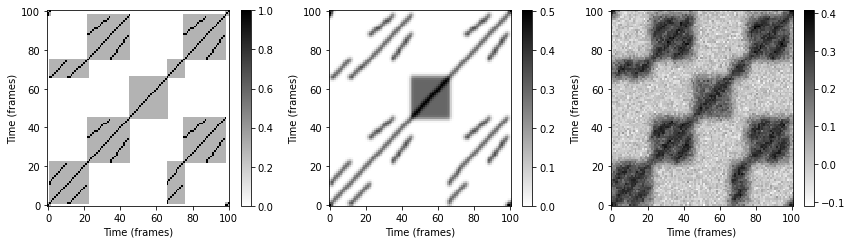

In [2]:
def generate_ssm_from_annotation(ann, label_ann=None, score_path=1.0, score_block=0.5, main_diagonal=True,
                                 smooth_sigma=0.0, noise_power=0.0):
    """Generation of a SSM

    Notebook: C4/C4S2_SSM-Synthetic.ipynb

    Args:
        ann (list): Description of sections (see explanation above)
        label_ann (dict): Specification of property (path, block relation) (Default value = None)
        score_path (float): SSM values for occurring paths (Default value = 1.0)
        score_block (float): SSM values of blocks covering the same labels (Default value = 0.5)
        main_diagonal (bool): True if a filled main diagonal should be enforced (Default value = True)
        smooth_sigma (float): Standard deviation of a Gaussian smoothing filter.
            filter length is 4*smooth_sigma (Default value = 0.0)
        noise_power (float): Variance of additive white Gaussian noise (Default value = 0.0)

    Returns:
        S (np.ndarray): Generated SSM
    """
    N = ann[-1][1] + 1
    S = np.zeros((N, N))

    if label_ann is None:
        all_labels = [s[2] for s in ann]
        labels = list(set(all_labels))
        label_ann = {l: [True, True] for l in labels}

    for s in ann:
        for s2 in ann:
            if s[2] == s2[2]:
                if (label_ann[s[2]])[1]:
                    S[s[0]:s[1]+1, s2[0]:s2[1]+1] = score_block

                if (label_ann[s[2]])[0]:
                    length_1 = s[1] - s[0] + 1
                    length_2 = s2[1] - s2[0] + 1

                    if length_1 >= length_2:
                        scale_fac = length_2 / length_1
                        for i in range(s[1] - s[0] + 1):
                            S[s[0]+i, s2[0]+int(i*scale_fac)] = score_path
                    else:
                        scale_fac = length_1 / length_2
                        for i in range(s2[1] - s2[0] + 1):
                            S[s[0]+int(i*scale_fac), s2[0]+i] = score_path
    if main_diagonal:
        for i in range(N):
            S[i, i] = score_path
    if smooth_sigma > 0:
        S = scipy.ndimage.gaussian_filter(S, smooth_sigma)
    if noise_power > 0:
        S = S + np.sqrt(noise_power) * np.random.randn(S.shape[0], S.shape[1])
    return S

figsize = (12,3.5)
fig, ax = plt.subplots(1, 3, figsize=figsize)

S = generate_ssm_from_annotation(ann_frames, score_path=1, score_block=0.3)
libfmp.b.plot_matrix(S, ax=[ax[0]], xlabel='Time (frames)', ylabel='Time (frames)');

label_ann = {'A':[True, False], 'B':[True, False], 'C':[False, True], '' : [True, False]}
S = generate_ssm_from_annotation(ann_frames, label_ann, score_path=1, score_block=0.3, smooth_sigma=1)
libfmp.b.plot_matrix(S, ax=[ax[1]], xlabel='Time (frames)', ylabel='Time (frames)');

S = generate_ssm_from_annotation(ann_frames, score_path=1, score_block=0.2, smooth_sigma=2, noise_power=0.001)
libfmp.b.plot_matrix(S, ax=[ax[2]], xlabel='Time (frames)', ylabel='Time (frames)');
plt.tight_layout()
plt.show() 

## Examples

We now consider some examples that show how the function for generating SSMs can be used to gain a deeper understanding of the relation between musical structures ans SSMs. 


* Following Exercise 4.9a of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we consider as first example a piece of music having the musical structure $A_1B_1B_2A_2A_3$, where we assume that corresponding parts are repeated in exactly the same way. Furthermore, assume that the $A$-part and $B$-part segments are completely unrelated to each other and that a $B$-part segment has exactly twice the length of an $A$-part segment.

* Following Exercise 4.9b of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we consider as second example a piece having the musical structure $A_1A_2A_3A_4$, where the four parts are repeated with increasing tempo. In particular, we assume that $A_1$ lasts $20$ seconds, $A_2$ lasts $15$ seconds,  $A_3$ lasts $10$ seconds,  and $A_4$ lasts $5$ seconds.

* Following Figure 4.27 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we consider as third example a piece having the musical structure $A_1A_2B_1B_2A_3A_4B_3B_4CA_5A_6$, where the $C$ part is homogeneous and has twice the length of the $A$ and $B$ parts.

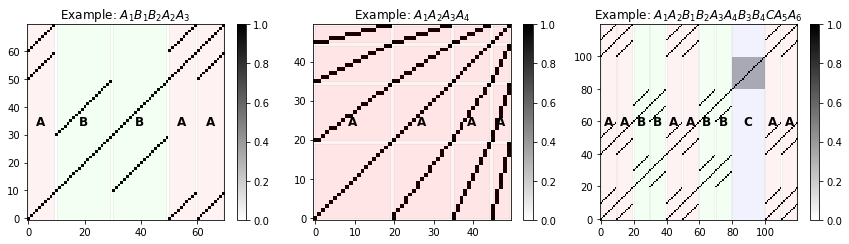

In [3]:
color_ann = {'A': [1, 0, 0, 0.2], 'B': [0, 1, 0, 0.2], 'C': [0, 0, 1, 0.2], '': [1, 1, 1, 0.2]}

figsize = (12,3.5)
fig, ax = plt.subplots(1, 3, figsize=figsize)

ann_1 = [[0, 9, 'A'], [10, 29, 'B'], [30, 49, 'B'], [50, 59, 'A'], [60, 69, 'A']]
S = generate_ssm_from_annotation(ann_1, score_path=1, score_block=0)
fig_im, ax_im, im = libfmp.b.plot_matrix(S, ax=[ax[0]], xlabel='', ylabel='', title=r'Example: $A_1B_1B_2A_2A_3$');
libfmp.b.plot_segments_overlay(ann_1, ax=ax_im[0],edgecolor='k',
                               print_labels=True, colors = color_ann, alpha=0.05)
#libfmp.b.plot_segments_overlay(ann, ax=ax_im[0], direction='vertical', edgecolor='k', colors = color_ann, alpha=0.05)

ann_2 = [[0, 19, 'A'], [20, 34, 'A'], [35, 44, 'A'], [45, 49, 'A']]
S = generate_ssm_from_annotation(ann_2, score_path=1, score_block=0)
fig_im, ax_im, im = libfmp.b.plot_matrix(S, ax=[ax[1]], xlabel='', ylabel='', title=r'Example: $A_1A_2A_3A_4$');
libfmp.b.plot_segments_overlay(ann_2, ax=ax_im[0],edgecolor='k', 
                               print_labels=True, colors = color_ann, alpha=0.05)
libfmp.b.plot_segments_overlay(ann_2, ax=ax_im[0], direction='vertical', edgecolor='k', 
                               print_labels=False, colors = color_ann, alpha=0.05)


ann_3 = [[0, 9, 'A'], [10, 19, 'A'], [20, 29, 'B'], [30, 39, 'B'],
         [40, 49, 'A'], [50, 59, 'A'], [60, 69, 'B'], [70, 79, 'B'],
         [80, 99, 'C'], [100, 109, 'A'], [110, 119, 'A']]
label_ann_3 = {'A':[True, False], 'B':[True, False], 'C':[False, True]}
S = generate_ssm_from_annotation(ann_3, label_ann_3, score_path=1, score_block=0.3)
fig_im, ax_im, im = libfmp.b.plot_matrix(S, ax=[ax[2]], xlabel='', ylabel='', title=r'Example: $A_1A_2B_1B_2A_3A_4B_3B_4CA_5A_6$');
libfmp.b.plot_segments_overlay(ann_3, ax=ax_im[0],edgecolor='k', 
                               print_labels=True, colors = color_ann, alpha=0.05)

plt.tight_layout()
plt.show() 

## Further Notes

Synthetically generating and visualizing self-similarity matrices is a very instructive way for gaining a deeper understanding of structural properties of these matrices and their relation to musical annotations. Furthermore, **synthetic SSMs** are useful for debugging and testing automated procedures for music structure analysis. However, synthetic SSMs should only be used as **sanity check** and should not replace the evaluation based on real music examples. In practice, SSMs computed from music and audio representations are typically far from being ideal. First, two sections annotated by a human with the same label (i.e., sections that correspond to the same part) may differ substantially on the musical level (e.g., variations on the note level), the acoustic level (e.g., instrumentation, dynamics), and temporal level (e.g., tempo changes, pauses). This typically leads to **fragmented, distorted, and noisy path and block structures**. Furthermore, humans often do not agree on the musical structure of a given piece, and there may exist alternative valid annotations. Finally, SSMs are typically computed on the basis of [feature representations](../C4/C4S2_SSM.html) that are extracted from music recordings. The type of feature representation has a significant influence on the structural properties of the resulting SSM. In particular, one often finds **combinations of path-like and block-like structures** expressing various similarity relations between musical segments at the same time. In summary, to understand the benefits and limitations of a given music structure analysis approach one needs to consider [**real SSMs**](../C4/C4S2_SSM.html) that have been derived from music and audio representations. 

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Tim Zunner.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>